In [45]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from h2o.estimators.deeplearning import H2ODeepLearningEstimator   # h2o deep learning model
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 1003 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators  


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,52 mins 12 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_buynow_8j4mge
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.991 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
tic = time.time()

In [3]:
data = pd.read_csv('../A_01/hmda_train_preprocessed.csv')
test = pd.read_csv('../A_01/hmda_test_preprocessed.csv')

## Basic data exploration

### Variable summary statistics

In [4]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [5]:
data[x_names + [y_name]].describe()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,0.960328,0.928027,0.000617,1.518971e-16,3.813309e-16,-1.243723e-15,-6.991775e-15,2.016754e-15,4.592073e-16,9.179888e-16,0.096702
std,0.195189,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,1.000000,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,1.000000,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,1.000000,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,1.000000,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


### Variable type

In [6]:
data[x_names].dtypes

term_360                          int64
conforming                        int64
debt_to_income_ratio_missing      int64
loan_amount_std                 float64
loan_to_value_ratio_std         float64
no_intro_rate_period_std        float64
intro_rate_period_std           float64
property_value_std              float64
income_std                      float64
debt_to_income_ratio_std        float64
dtype: object

### Histogram

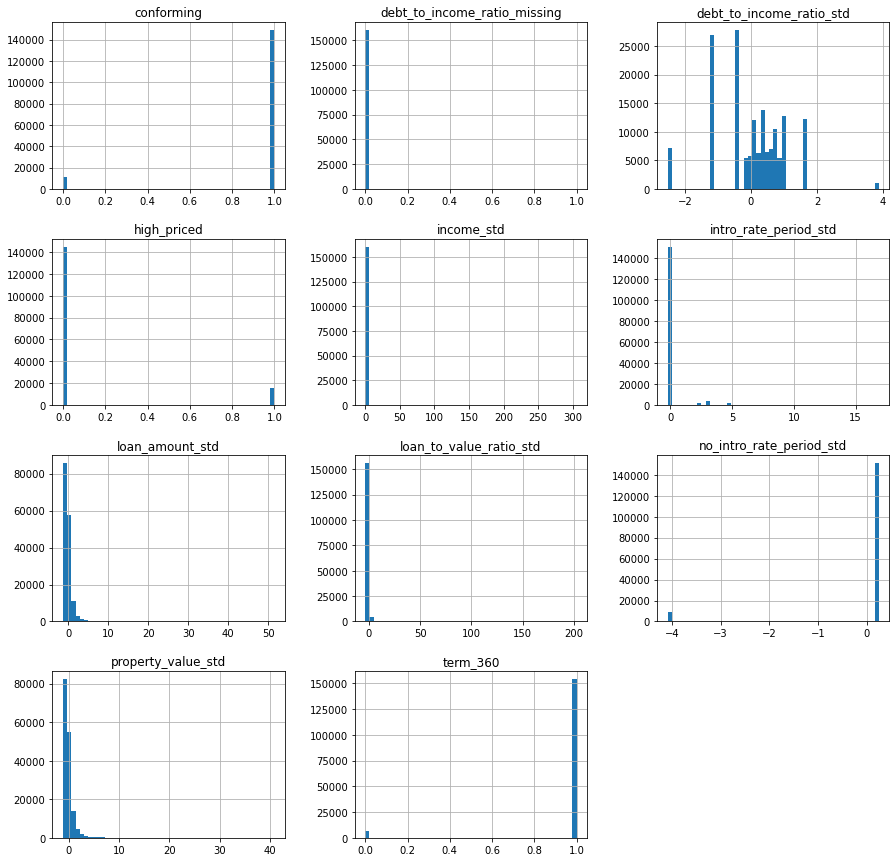

In [7]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

### Correlation matrix

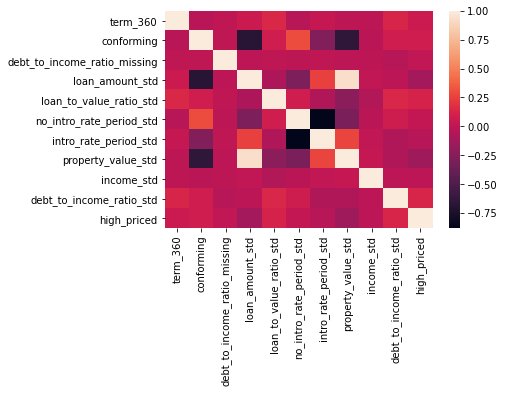

In [8]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

### Calculate Peason Correlation

In [9]:
# Pearson correlation between inputs and target
# is last column of correlation matrix
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr

,Pearson Correlation Coefficient
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,-0.031716
property_value_std,-0.137319
income_std,-0.007911
debt_to_income_ratio_std,0.128645


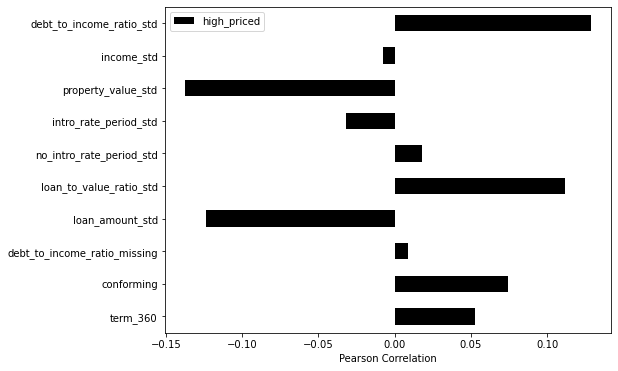

In [10]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

## Train interpretable models

### Split data into train and validation partitions

In [11]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 111972, columns = 23
# benchmark - Validation data rows = 48366, columns = 23

Train data rows = 111972, columns = 23
Validation data rows = 48366, columns = 23


### Elastic net

### Define wrapper function for grid search

In [12]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.001, 0.005, 0.01, 0.023, 0.045, 0.05, 0.08, 0.1, 0.25, 0.37, 0.5, 0.63, 0.78, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

### Fit elastic net with grid search

In [13]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 42.50 s.


### Basic AUC assessment

In [14]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7630.


### Write submission file

In [15]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('Group_2_best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

In [16]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_83d227779f296fa9aa303dc483474226.hex_model_python_1622905657671_1_model_1


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.001, lambda = 0.1301 )","nlambda = 100, lambda.max = 4.0658, lambda.min = 0.1301, lambda.1s...",10,10,49,Key_Frame__upload_83d227779f296fa9aa303dc483474226.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08359766679106448
RMSE: 0.2891326110819471
LogLoss: 0.2975598308786252
Null degrees of freedom: 111971
Residual degrees of freedom: 111961
Null deviance: 70877.86632513803
Residual deviance: 66636.73876628284
AIC: 66658.73876628284
AUC: 0.758054698957882
AUCPR: 0.2186437792994284
Gini: 0.516109397915764

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11580345578855507: 


,,0,1,Error,Rate
0,0,78387.0,22821.0,0.2255,(22821.0/101208.0)
1,1,4552.0,6212.0,0.4229,(4552.0/10764.0)
2,Total,82939.0,29033.0,0.2445,(27373.0/111972.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.115803,0.312184,128.0
1,max f2,0.105097,0.468738,165.0
2,max f0point5,0.127714,0.263241,90.0
3,max accuracy,0.217197,0.903860,10.0
4,max precision,0.217197,0.470588,10.0
5,max recall,0.004963,1.000000,395.0
6,max specificity,0.997123,0.999960,0.0
7,max absolute_mcc,0.109335,0.245263,150.0
8,max min_per_class_accuracy,0.110149,0.696151,147.0
9,max mean_per_class_accuracy,0.106532,0.701766,160.0



Gains/Lift Table: Avg response rate:  9.61 %, avg score:  9.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.152322,2.804947,2.804947,0.269643,0.173129,0.269643,0.173129,0.028056,0.028056,180.494705,180.494705,0.019974
1,2,0.020023,0.145726,2.966831,2.885961,0.285205,0.148588,0.277431,0.160847,0.029729,0.057785,196.683141,188.596143,0.041779
2,3,0.030008,0.142298,3.061187,2.944266,0.294275,0.144077,0.283036,0.155267,0.030565,0.088350,206.118686,194.426561,0.064548
3,4,0.040001,0.139392,2.956193,2.947245,0.284182,0.140814,0.283322,0.151656,0.029543,0.117893,195.619297,194.724545,0.086176
4,5,0.050013,0.137419,2.561175,2.869962,0.246209,0.138376,0.275893,0.148998,0.025641,0.143534,156.117478,186.996237,0.103468
5,6,0.100007,0.129413,2.547653,2.708837,0.244909,0.133023,0.260404,0.141012,0.127369,0.270903,154.765319,170.883656,0.189072
6,7,0.150011,0.124290,2.149605,2.522426,0.206644,0.126715,0.242484,0.136246,0.107488,0.378391,114.960487,152.242600,0.252670
7,8,0.200005,0.120137,1.969739,2.384273,0.189353,0.122135,0.229203,0.132719,0.098476,0.476867,96.973915,138.427280,0.306308
8,9,0.300004,0.112656,1.607238,2.125269,0.154506,0.116310,0.204305,0.127249,0.160721,0.637588,60.723792,112.526888,0.373489
9,10,0.400029,0.105985,1.257582,1.908308,0.120893,0.109383,0.183448,0.122782,0.125790,0.763378,25.758222,90.830847,0.401993




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.0850266246710785
RMSE: 0.2915932521014135
LogLoss: 0.3020235004975676
Null degrees of freedom: 48365
Residual degrees of freedom: 48355
Null deviance: 31025.68631665416
Residual deviance: 29218.347004119118
AIC: 29240.347004119118
AUC: 0.762954982113599
AUCPR: 0.2304985011688043
Gini: 0.525909964227198

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11661499270921932: 


,,0,1,Error,Rate
0,0,34265.0,9360.0,0.2146,(9360.0/43625.0)
1,1,1987.0,2754.0,0.4191,(1987.0/4741.0)
2,Total,36252.0,12114.0,0.2346,(11347.0/48366.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.116615,0.326787,123.0
1,max f2,0.108713,0.475905,151.0
2,max f0point5,0.131187,0.279182,75.0
3,max accuracy,1.000000,0.901935,0.0
4,max precision,0.211557,0.333333,9.0
5,max recall,0.005413,1.000000,396.0
6,max specificity,1.000000,0.999954,0.0
7,max absolute_mcc,0.110788,0.254856,143.0
8,max min_per_class_accuracy,0.110368,0.701364,145.0
9,max mean_per_class_accuracy,0.108713,0.705173,151.0



Gains/Lift Table: Avg response rate:  9.80 %, avg score:  9.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010007,1.525559e-01,2.929811,2.929811,0.287190,0.176264,0.287190,0.176264,0.029319,0.029319,192.981133,192.981133,0.021410
1,2,0.020055,1.457279e-01,3.106674,3.018425,0.304527,0.148582,0.295876,0.162395,0.031217,0.060536,210.667385,201.842493,0.044880
2,3,0.030000,1.425244e-01,3.202595,3.079477,0.313929,0.144300,0.301861,0.156396,0.031850,0.092386,220.259549,207.947664,0.069165
3,4,0.040007,1.400875e-01,2.908734,3.036769,0.285124,0.141134,0.297674,0.152579,0.029108,0.121493,190.873356,203.676881,0.090341
4,5,0.050014,1.375613e-01,3.140589,3.057541,0.307851,0.138570,0.299711,0.149776,0.031428,0.152921,214.058913,205.754146,0.114090
5,6,0.100008,1.295196e-01,2.582054,2.819847,0.253102,0.133134,0.276411,0.141457,0.129087,0.282008,158.205413,181.984694,0.201779
6,7,0.150002,1.243482e-01,2.168588,2.602791,0.212572,0.126825,0.255134,0.136580,0.108416,0.390424,116.858794,160.279053,0.266550
7,8,0.200017,1.203241e-01,2.058042,2.466575,0.201736,0.122306,0.241782,0.133011,0.102932,0.493356,105.804170,146.657517,0.325218
8,9,0.300004,1.128013e-01,1.580031,2.171101,0.154880,0.116495,0.212819,0.127506,0.157984,0.651339,58.003149,117.110134,0.389517
9,10,0.400012,1.061515e-01,1.122033,1.908821,0.109986,0.109519,0.187109,0.123009,0.112213,0.763552,12.203334,90.882078,0.403048




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-05 11:08:22,0.000 sec,3,.41E1,9,0.630321,0.638740,0.001,NaN,...,,,,,,,,,,
1,,2021-06-05 11:08:22,0.142 sec,4,.37E1,9,0.630037,0.638451,0.001,NaN,...,,,,,,,,,,
2,,2021-06-05 11:08:22,0.372 sec,5,.34E1,9,0.629735,0.638143,0.001,NaN,...,,,,,,,,,,
3,,2021-06-05 11:08:22,0.459 sec,6,.31E1,10,0.629409,0.637813,0.001,NaN,...,,,,,,,,,,
4,,2021-06-05 11:08:22,0.540 sec,7,.28E1,10,0.629056,0.637455,0.001,NaN,...,,,,,,,,,,
5,,2021-06-05 11:08:23,0.639 sec,8,.26E1,10,0.628678,0.637073,0.001,NaN,...,,,,,,,,,,
6,,2021-06-05 11:08:23,0.761 sec,9,.23E1,10,0.628268,0.636659,0.001,NaN,...,,,,,,,,,,
7,,2021-06-05 11:08:23,0.825 sec,10,.21E1,10,0.627826,0.636214,0.001,NaN,...,,,,,,,,,,
8,,2021-06-05 11:08:23,0.891 sec,11,.19E1,10,0.627351,0.635737,0.001,NaN,...,,,,,,,,,,
9,,2021-06-05 11:08:23,0.978 sec,12,.18E1,11,0.626843,0.635227,0.001,NaN,...,,,,,,,,,,



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,0.164170,1.000000,0.209159
1,debt_to_income_ratio_std,0.158949,0.968196,0.202507
2,property_value_std,0.155786,0.948935,0.198479
3,loan_amount_std,0.142368,0.867202,0.181383
4,term_360,0.059855,0.364595,0.076258
5,conforming,0.051080,0.311139,0.065078
6,intro_rate_period_std,0.017464,0.106379,0.022250
7,no_intro_rate_period_std,0.015361,0.093567,0.019570
8,debt_to_income_ratio_missing,0.014636,0.089152,0.018647
9,income_std,0.005234,0.031883,0.006669


## Monotonic XGBoost

### Define utility function for random grid search

In [20]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

In [21]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

### Fit monotonic XGBoost with random grid search

In [22]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.01, 0.05, 0.3, 0.5, 0.7, 0.9],     # 0 - 1 limit
             'colsample_bylevel': [0.01, 0.05, 0.3, 0.5, 0.7, 0.9],    # 0 - 1 limit
             'eta': [0.005, 0.05, 0.5, 5, 10],
             'max_depth': [3, 5, 7, 11, 14],
             'reg_alpha': [0.0005, 0.005, 0.05, 5, 10],
             'reg_lambda': [0.0005, 0.005, 0.05, 5, 10],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4, 0.9, 1.3]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.01, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 10, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 1.3}
Grid search new best score discovered at iteration 1/50: 0.7893.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.05, 'eta': 5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'colsample_bytree': 0.5, 'c

---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 5, 'max_depth': 7, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'colsample_bytree': 0.05, 'colsample_bylevel': 0.05, 'eta': 0.05, 'max_depth': 11, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 42/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1003, 'cols

### Basic AUC assessment

In [23]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7928.


### Write submission file

In [24]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit= best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('group_2_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

# Explainable Boosting Machine

### Define utility function for random grid search

In [25]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}
    
    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

### Fit EBM with random grid search

In [26]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64, 86, 99],
             'interactions': [3, 5, 10, 15, 20, 50],
             'outer_bags': [4, 8, 12, 16, 18], 
             'inner_bags': [0, 4, 6, 8],
             'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'validation_size': [0.1, 0.25, 0.5, 0.75],
             'min_samples_leaf': [1, 2, 5, 10, 20],
             'max_leaves': [1, 3, 5, 10, 50]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 1003, 'max_bins': 512, 'max_interaction_bins': 86, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.1, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 10}
Grid search new best score discovered at iteration 1/10: 0.8253.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 1003, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 20, 'outer_bags': 16, 'inner_bags': 0, 'learning_rate': 0.1, 'validation_size': 0.75, 'min_samples_leaf': 5, 'max_leaves': 50}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 1003, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.1, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_l

### Basic AUC assessment

In [27]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8259.


### Variable Importance graph

In [31]:
X_train = train[x_names]
X_valid = valid[x_names]
y_train = train[y_name]
y_valid = train[y_name]

In [32]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_per...
                                             'loan_amount_std x '
                                             'no_intro_rate_period_s

In [69]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/4700899840/ -->

### Write submission file

In [28]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('Group_2_best_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

### End timer

In [68]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 7725.28 s.


### Shutdown h2o

In [36]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_a07f closed.
